In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load energy data
energy_df = pd.read_csv('../data/energy_import_export.csv')

# Load solar self-consumption data
solar_df = pd.read_csv('../data/solar_self_consumption_main_building.csv')

# Load meteorological data
met_df = pd.read_csv('../data/met_data.csv')


In [5]:
solar_df.head()
# drop columns "Unnamed: 0"
solar_df = solar_df.drop(columns=['Unnamed: 0'])

In [415]:
# Convert timestamp columns to datetime
energy_df['Tidspunkt'] = pd.to_datetime(energy_df['Tidspunkt'], format="mixed")
solar_df['starting_at'] = pd.to_datetime(solar_df['starting_at'], format='mixed')

# remove utc from the time string
met_df['starting_at'] = met_df['starting_at'].str.split('+').str[0]
met_df['starting_at'] = pd.to_datetime(met_df['starting_at'], format='mixed')




In [416]:
# Rename columns for easier reference
energy_df.rename(columns={
    'Energikilde': 'energy_source',
    'Retning': 'direction',
    'Målernavn': 'meter_name',
    'Måler-Id': 'meter_id',
    'Verdi': 'value',
    'Tidspunkt': 'timestamp'
}, inplace=True)

# rename starting at to timestamp for solar_df and met_df
solar_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)
met_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)


In [417]:
meter_property_mapping = {
    '707057500042745649': 10724, #main building
    '707057500038344962': 10703, # building A
    '707057500085390523': 4462, # building B
    '707057500042201572': 4746 # building C
}
# Strip any leading/trailing spaces in the 'meter_id' column

energy_df['meter_id'] = energy_df['meter_id'].astype(str)
energy_df['meter_id'] = energy_df['meter_id'].str.strip()

energy_df['property_id'] = energy_df['meter_id'].map(meter_property_mapping)

energy_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724


In [418]:
# Resample met_df to daily granularity (mean aggregation)
# met_df_daily = met_df.set_index('timestamp').resample('D').mean().reset_index()
# met_df_daily["timestamp"] = pd.to_datetime(met_df_daily["timestamp"].dt.date)

merged_df = pd.merge(energy_df, met_df, on=['property_id', 'timestamp'], how='left')


In [419]:
merged_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703,16.2,1.4,281.6,0.4,0.0
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746,18.2,4.8,14.4,0.0,0.0
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724,17.4,1.8,356.1,0.9,0.0
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462,15.6,0.9,243.3,0.9,0.0
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724,17.4,1.8,356.1,0.9,0.0


In [420]:
met_df.tail()

,property_id,timestamp,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
41179,10724,2023-07-01 01:00:00,13.2,2.0,246.5,0.4,0.0
41180,4462,2023-07-01 00:00:00,12.0,0.7,220.3,0.5,0.0
41181,4746,2023-07-01 00:00:00,15.2,3.9,247.0,0.2,0.0
41182,10703,2023-07-01 00:00:00,12.9,1.0,275.7,0.7,0.0
41183,10724,2023-07-01 00:00:00,13.6,1.6,251.5,0.5,0.0


In [421]:
# Check for missing values
print("total number of rows", merged_df.shape[0])
print("rows missing weather data \n",merged_df.isnull().sum())

# Fill or drop missing values as appropriate
# merged_df.dropna(inplace=True)
rows_with_missing_values = merged_df[merged_df.isnull().any(axis=1)]
rows_with_missing_values.head()


total number of rows 54476
rows missing weather data 
 energy_source       0
direction           0
meter_name          0
meter_id            0
value               0
timestamp           0
property_id         0
temperature       385
wind_speed        385
wind_direction    385
cloud_fraction    385
precipitation     385
dtype: int64


,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
29071,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.0,2024-02-06 06:00:00,10724,NaN,NaN,NaN,NaN,NaN
29072,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,37.4,2024-02-06 06:00:00,10703,NaN,NaN,NaN,NaN,NaN
29073,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,37.8,2024-02-06 06:00:00,10724,NaN,NaN,NaN,NaN,NaN
29074,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,46.4,2024-02-06 06:00:00,4746,NaN,NaN,NaN,NaN,NaN
29075,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,34.4,2024-02-06 06:00:00,4462,NaN,NaN,NaN,NaN,NaN


In [422]:
# Separate import (consumption) and export (production)
import_df = merged_df[merged_df['direction'] == 'IMPORT']
export_df = merged_df[merged_df['direction'] == 'EXPORT']


In [423]:
# For property_id 10724 (main building)
main_building_import = import_df[import_df['property_id'] == 10724]

main_building_export = export_df[export_df['property_id'] == 10724]

# Merge with solar self-consumption data
main_building_df = pd.merge(main_building_import, solar_df, left_on='timestamp', right_on='timestamp', how='left')

# Replace NaN in solar_consumption with 0
main_building_df['solar_consumption'].fillna(0, inplace=True)

# Calculate total consumption including self-consumed solar energy
main_building_df['total_consumption'] = main_building_df['value'] + main_building_df['solar_consumption']


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_62088/1695209657.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_building_df['solar_consumption'].fillna(0, inplace=True)


In [424]:
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


In [425]:
# Get import data for reference buildings
ref_buildings = [10703, 4462, 4746]
ref_buildings_df = import_df[import_df['property_id'].isin(ref_buildings)]

# Aggregate data to daily or monthly consumption if needed
main_daily_consumption = main_building_df.groupby(main_building_df['timestamp'].dt.date)['total_consumption'].sum()#.reset_index()
ref_daily_consumption = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.date])['value'].sum().reset_index()



In [426]:
main_daily_consumption.head()

timestamp
2023-07-01    1032.420978
2023-07-02     826.556745
2023-07-03     991.655659
2023-07-04     988.668543
2023-07-05    1023.232176
Name: total_consumption, dtype: float64

In [427]:
# Identify hourly peaks
main_building_peaks = main_building_df.groupby(main_building_df['timestamp'].dt.month)['total_consumption'].max()#.reset_index()
ref_buildings_peaks = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.month])['value'].max().reset_index()


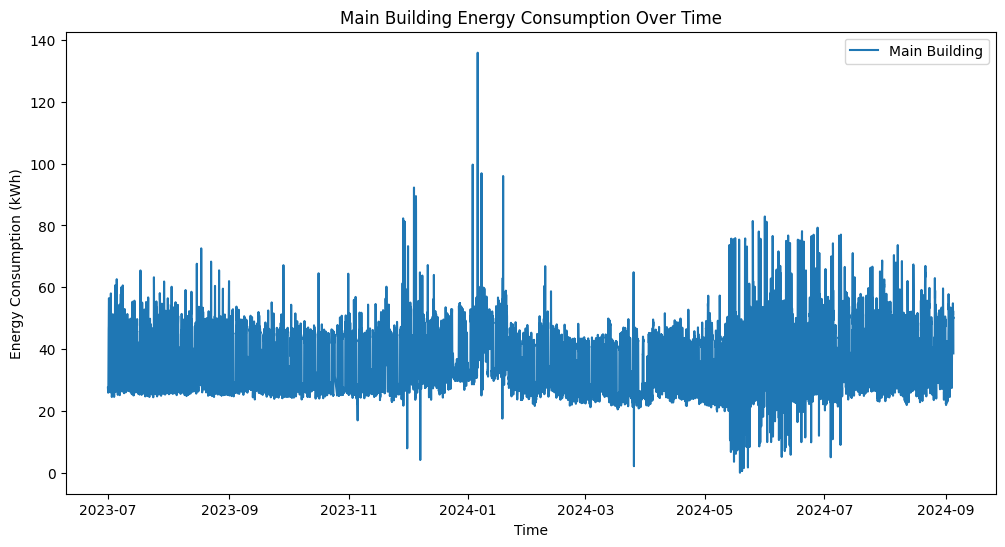

In [428]:
# Plot total consumption over time for the main building
plt.figure(figsize=(12,6))
plt.plot(main_building_df['timestamp'], main_building_df['total_consumption'], label='Main Building')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Main Building Energy Consumption Over Time')
plt.legend()
plt.show()


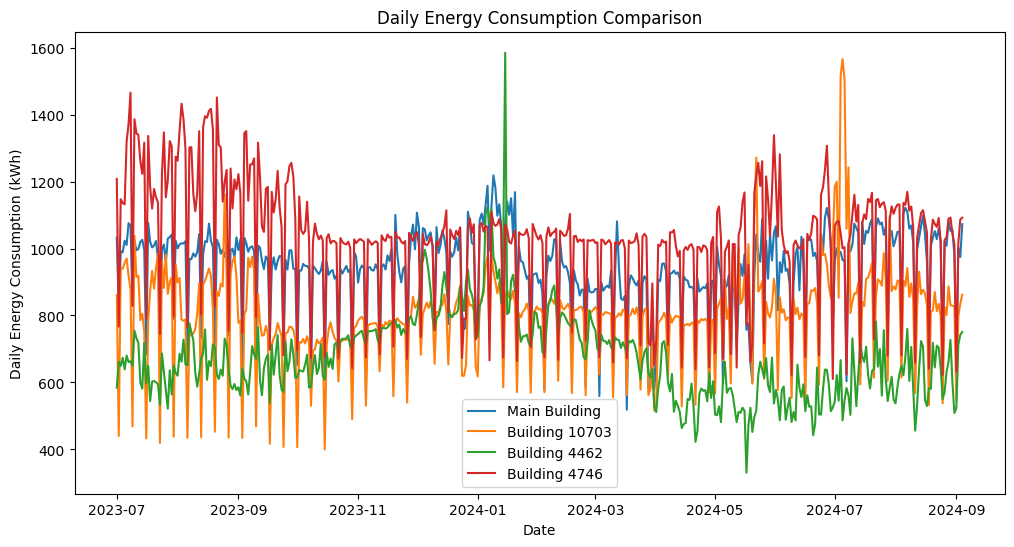

In [429]:
# Plot average daily consumption
plt.figure(figsize=(12,6))
sns.lineplot(data=main_daily_consumption, label='Main Building')
for pid in ref_buildings:
    data = ref_daily_consumption[ref_daily_consumption['property_id'] == pid]
    sns.lineplot(x='timestamp', y='value', data=data, label=f'Building {pid}')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.title('Daily Energy Consumption Comparison')
plt.legend()
plt.show()


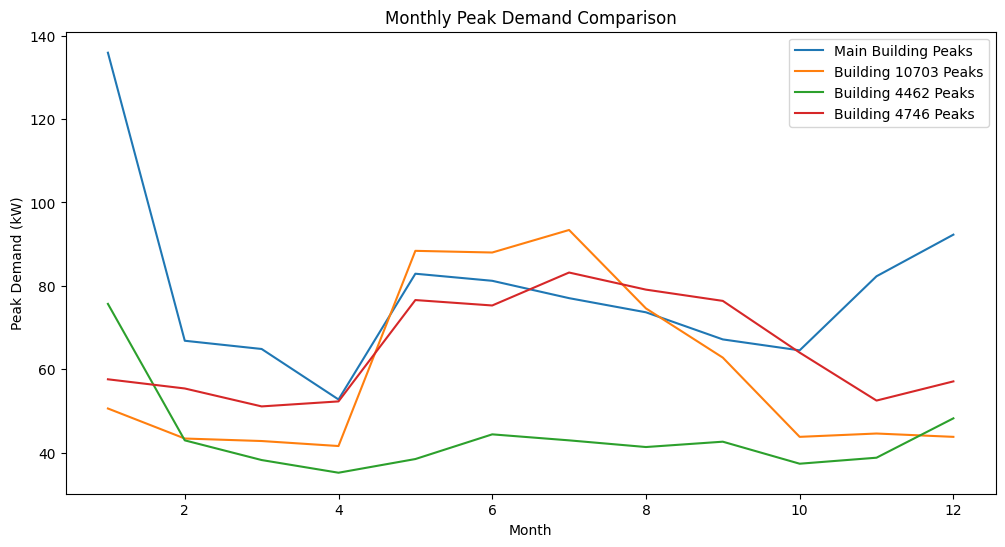

In [430]:
# Plot monthly peak demand
plt.figure(figsize=(12,6))
plt.plot(main_building_peaks.index, main_building_peaks.values, label='Main Building Peaks')
for pid in ref_buildings:
    data = ref_buildings_peaks[ref_buildings_peaks['property_id'] == pid]
    plt.plot(data['timestamp'], data['value'], label=f'Building {pid} Peaks')
plt.xlabel('Month')
plt.ylabel('Peak Demand (kW)')
plt.title('Monthly Peak Demand Comparison')
plt.legend()
plt.show()


In [431]:
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


In [432]:
# Merge main building data with meteorological data
main_met_df = main_building_df
main_met_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


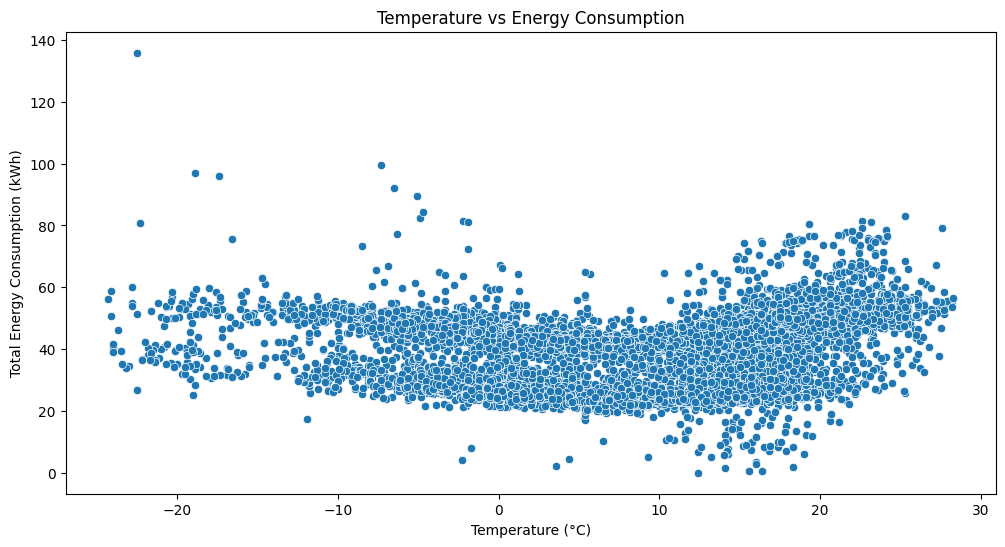

In [433]:
# Analyze correlation between temperature and energy consumption
plt.figure(figsize=(12,6))
sns.scatterplot(x='temperature', y='total_consumption', data=main_met_df)
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Energy Consumption (kWh)')
plt.title('Temperature vs Energy Consumption')
plt.show()


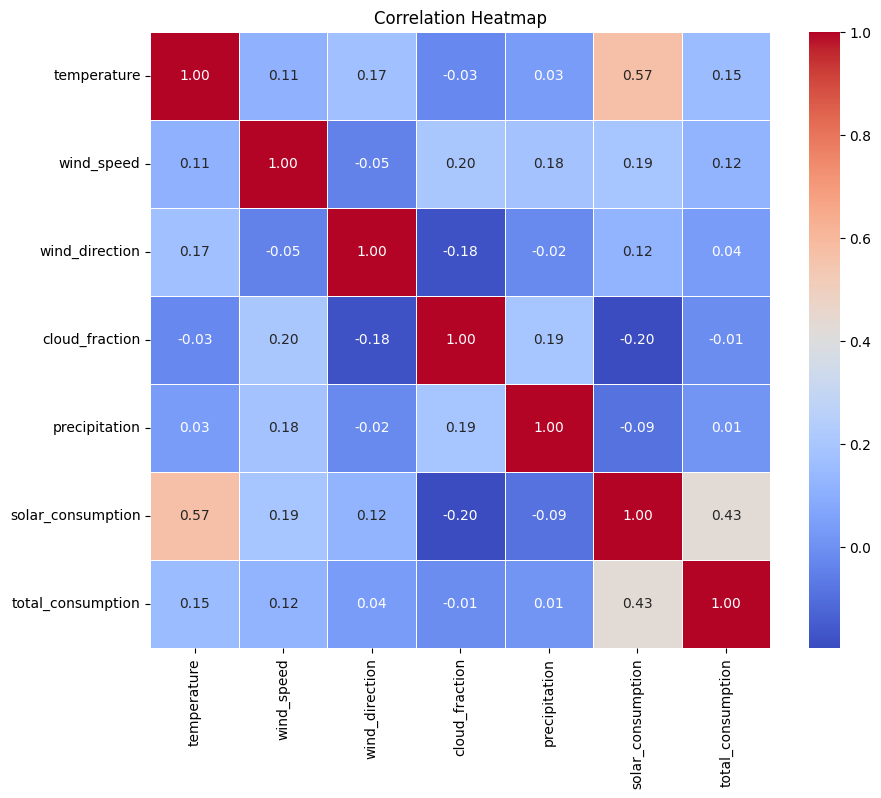

In [434]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns to compute the correlation
correlation_columns = ['temperature', 'wind_speed', 'wind_direction', 'cloud_fraction', 
                       'precipitation', 'solar_consumption', 'total_consumption']

# Compute the correlation matrix
correlation_matrix = main_met_df[correlation_columns].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Set plot title and labels
plt.title('Correlation Heatmap')
plt.show()


# TODO list
- se på hvor mye som eksporteres.
- Sammenligne import og eksport for byggingene